In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats.stats import pearsonr

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Load Data

In [2]:
# Read in the Boston housing data.
from sklearn.datasets import load_boston
boston = load_boston()

df = pd.DataFrame(boston.data)
df.columns = boston.feature_names
df['med_val'] = boston.target

#Establishing graphing parameters
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 12

In [3]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## Data Exploration

In [ ]:
#Questions to address:
#Which features most correlate to med_val?
#can we predict med_val?

In [55]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,med_val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
#no nulls, clean dataset given it's from scikit-learn
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
med_val    0
dtype: int64

In [5]:
df.describe(include='all')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,med_val
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


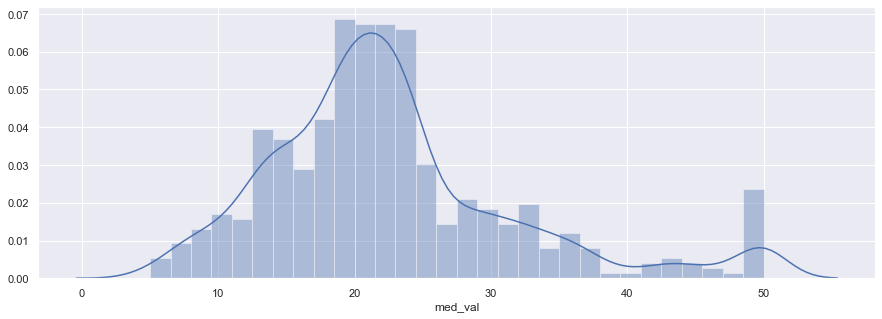

In [7]:
sns.set(rc={'figure.figsize':(15,5)})
sns.distplot(df['med_val'], bins=30)
plt.show()

## Modeling (Linear Regression using all features)

In [8]:
X = df[df.columns.drop(['med_val'])]
y = df['med_val']

print(X.shape)
print(y.shape)

(506, 13)
(506,)


In [16]:
#instantiate, fit, and predict baseline model
lr_mod = LinearRegression()
lr_mod.fit(X, y)
lr_preds = lr_mod.predict(X)

#baseline accuracy score .741
lr_mod.score(X,y)

0.7406426641094095

In [32]:
#Age, INDUS, and NOX are not statistically significant at 5% confidence
X_constant = sm.add_constant(X)
mod = sm.OLS(y,X_constant).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                med_val   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Tue, 01 Sep 2020   Prob (F-statistic):          6.72e-135
Time:                        11:54:22   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4595      5.103      7.144      0.0

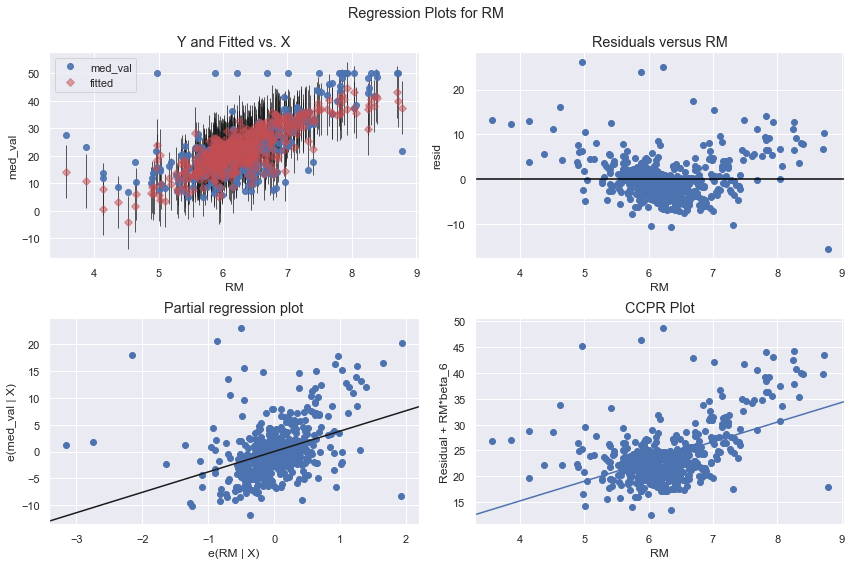

In [20]:
#residuals for RM are not random, closer to 0 around 5-7 RMs
#residuals indicate that there are systematic errors around higher and lower RM count
from statsmodels.formula.api import ols

fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(mod, 'RM', fig=fig)

In [17]:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')

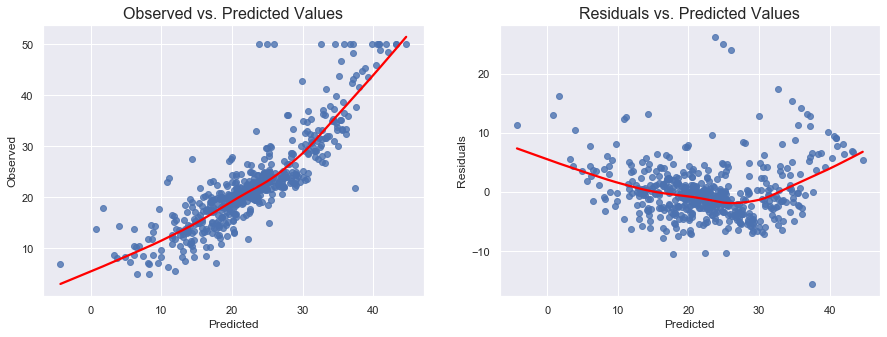

In [21]:
#linear assumption not satisfied
#points are not symmetrically distributed around the lines
linearity_test(mod, y)

In [22]:
#residuals average about 0
mod.resid.mean()

6.392778269857423e-15

In [34]:
#Tax, RAD, NOX, DIS, AGE, INDUS all higher vif, consider for removal
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns[1:]).T

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
vif,1.792192,2.298758,3.991596,1.073995,4.39372,1.933744,3.100826,3.955945,7.484496,9.008554,1.799084,1.348521,2.941491


In [39]:
import statsmodels.stats.api as sms

def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')


 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  6.512179e+01
p-value                        6.265431e-09
f-value                        5.590227e+00
f p-value                      1.495776e-09

 Goldfeld-Quandt test ----
                    value
F statistic  2.431147e+00
p-value      7.302072e-12

 Residuals plots ----


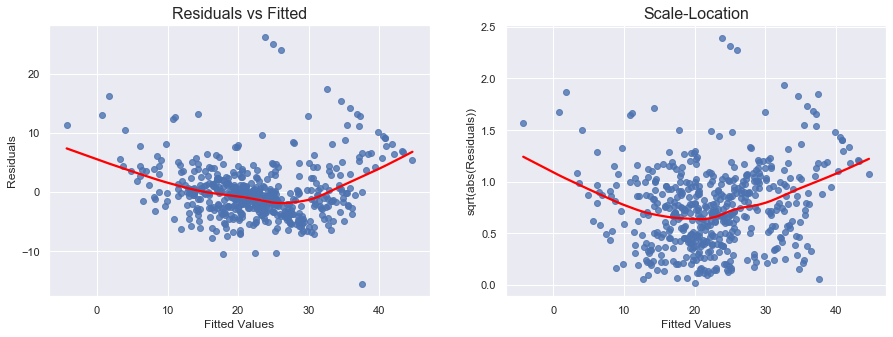

In [40]:
# The residuals are not random, there is a slight u-shape pattern
# reject the hypothesis of homoscedasticity
homoscedasticity_test(mod)

1.0783751186797235


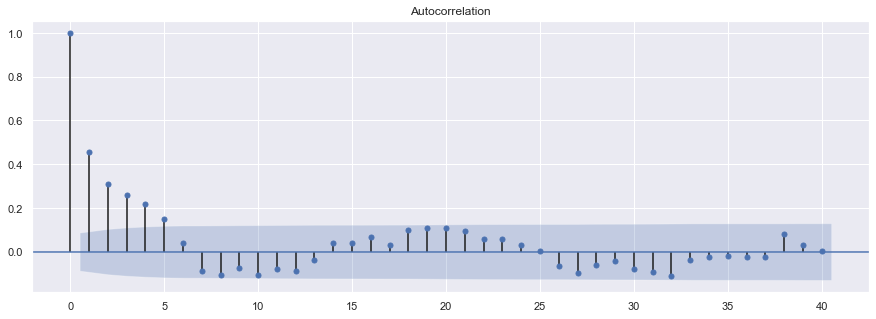

In [47]:
#Dubin-watson test for autocorrelation
# Durbin-watson value of 1.078, slight positive autocorrelation
from statsmodels.stats.stattools import durbin_watson
print(durbin_watson(mod.resid))
acf = smt.graphics.plot_acf(mod.resid, lags=40, alpha=0.05)

In [50]:
# cannot prove lack of correlation for any pair
for column in X.columns:
    corr_test = stats.pearsonr(X[column], mod.resid)
    print(f'Variable: {column} --- correlation: {corr_test[0]:.3f}, p-value: {corr_test[1]:.3f}')

Variable: const --- correlation: nan, p-value: nan
Variable: CRIM --- correlation: -0.0000, p-value: 1.0000
Variable: ZN --- correlation: -0.0000, p-value: 1.0000
Variable: INDUS --- correlation: 0.0000, p-value: 1.0000
Variable: CHAS --- correlation: 0.0000, p-value: 1.0000
Variable: NOX --- correlation: 0.0000, p-value: 1.0000
Variable: RM --- correlation: 0.0000, p-value: 1.0000
Variable: AGE --- correlation: 0.0000, p-value: 1.0000
Variable: DIS --- correlation: -0.0000, p-value: 1.0000
Variable: RAD --- correlation: -0.0000, p-value: 1.0000
Variable: TAX --- correlation: -0.0000, p-value: 1.0000
Variable: PTRATIO --- correlation: 0.0000, p-value: 1.0000
Variable: B --- correlation: -0.0000, p-value: 1.0000
Variable: LSTAT --- correlation: 0.0000, p-value: 1.0000


In [52]:
#more observations than features
df.shape

(506, 14)

In [53]:
#There is some variance in each feature
#NOX and CHAS particularly low variance
X.apply(np.var, axis = 0)

const          0.000000
CRIM          73.840360
ZN           542.861840
INDUS         46.971430
CHAS           0.064385
NOX            0.013401
RM             0.492695
AGE          790.792473
DIS            4.425252
RAD           75.666531
TAX        28348.623600
PTRATIO        4.677726
B           8318.280421
LSTAT         50.893979
dtype: float64

Jarque-Bera test ---- statistic: 783.1263, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9014, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.3329, p-value: 0.0000
Anderson-Darling test ---- statistic: 10.5207, 5% critical value: 0.7810
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


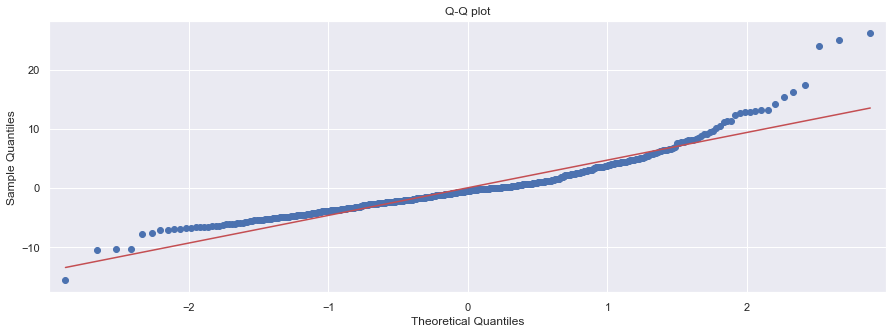

In [54]:
from scipy import stats

def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')

#the residuals do not follow a gaussian distribution
normality_of_residuals_test(mod)

## Modeling (Linear Regression with Target Features)

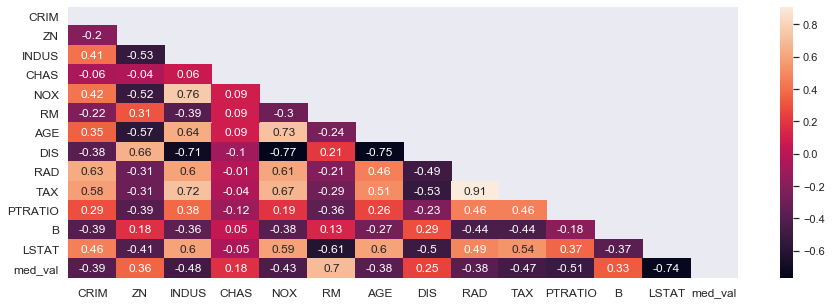

In [43]:
corr = df.corr().round(2)

fig, ax = plt.subplots(figsize=(15,5))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, annot=True, mask=mask, ax=ax)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)

#raise upper limit and lower lower limit to show top and bottom rows
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)

plt.show()

In [22]:
#filter-based feature selection
#I'll use features: LSTAT, PTRATIO, RM, ZN
corr['med_val'].sort_values()

LSTAT     -0.74
PTRATIO   -0.51
INDUS     -0.48
TAX       -0.47
NOX       -0.43
CRIM      -0.39
AGE       -0.38
RAD       -0.38
CHAS       0.18
DIS        0.25
B          0.33
ZN         0.36
RM         0.70
med_val    1.00
Name: med_val, dtype: float64

In [ ]:
#Pearson's correlation coefficient
from scikitlearn import f_regression()

In [35]:
X = df[['ZN','RM','LSTAT','PTRATIO']]
y = df['med_val']

In [36]:
print(X.shape)
print(y.shape)

(506, 4)
(506,)


In [37]:
lr_mod = LinearRegression()
lr_mod.fit(X, y)
lr_preds = lr_mod.predict(X)

In [38]:
lr_mod.score(X,y)
#baseline score is .679

0.6789744677198571

In [52]:
metrics.mean_squared_error(y, lr_preds)

27.100832949886456

In [51]:
coef = pd.DataFrame(df[['ZN','RM','LSTAT','PTRATIO']].columns, columns = ['features'])
coef['coef'] = pd.Series(lr_mod.coef_)
coef

,features,coef
0,ZN,-0.008449
1,RM,4.526442
2,LSTAT,-0.579749
3,PTRATIO,-0.955301


## Train-test split

In [41]:
X = df[['ZN','RM','LSTAT','PTRATIO']]
y = df['med_val']

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = .2, random_state = 421)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(404, 4) (102, 4)
(404,) (102,)


In [72]:
lr_mod = LinearRegression()
lr_mod.fit(X_train, y_train)
lr_pred = lr_mod.predict(X_test)

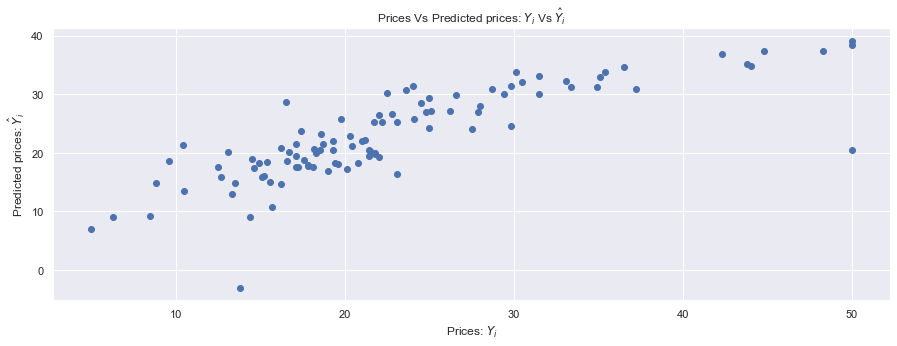

In [73]:
#plot predicted prices vs actuals
plt.scatter(y_test, lr_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices Vs Predicted prices: $Y_i$ Vs $\hat{Y}_i$")
plt.show()

In [74]:
#better than baseline?
lr_mod.score(X_test, y_test)

0.6753571559877042

In [75]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, lr_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, lr_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, lr_pred)))

Mean Absolute Error: 3.760031368732312
Mean Squared Error: 30.22672010715313
Root Mean Squared Error: 5.4978832387704575


## Cross Validation

In [67]:
from sklearn.model_selection import cross_val_score

cross_val_score(lr_mod, X_train, y_train, cv=5)

array([0.737392  , 0.70088039, 0.51172559, 0.72255274, 0.7002127 ])

In [68]:
cv_df = pd.DataFrame()
def cv_scores(model, X, y, cv):
    for cv_count in range(5,cv+1):
        cv_df[cv_count] = pd.Series(cross_val_score(model, X, y, cv=cv_count)).describe()
    return cv_df

In [69]:
cv_scores(lr_mod, X_train, y_train, cv=10)
#seems like less k-folds leads to better scores, less overfitting

,5,6,7,8,9,10
count,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000
mean,0.674553,0.676224,0.665786,0.672404,0.667110,0.680300
std,0.092354,0.123338,0.114894,0.120918,0.143305,0.129181
min,0.511726,0.437261,0.484579,0.427503,0.359893,0.404783
25%,0.700213,0.684974,0.597216,0.632447,0.640766,0.624875
50%,0.700880,0.708035,0.699295,0.692702,0.709847,0.687934
75%,0.722553,0.727000,0.741780,0.744225,0.763162,0.773627
max,0.737392,0.793406,0.798633,0.814161,0.823006,0.847863


## Modeling (KNN)

## RandomForrest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
rf.fit(X_train , y_train)
y_pred = rf.predict(X_test)

plt.scatter(Y_test, y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices Vs Predicted prices: $Y_i$ Vs $\hat{Y}_i$")
plt.show()

In [ ]:
print(sklearn.metrics.mean_absolute_error(Y_test, y_pred))
print(np.sqrt(mse))

In [ ]:
print(rf.score(X_test , y_test))

In [ ]:
sns.distplot(y_pred)

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

test_score = r2_score(y_test , y_pred)
spearman = spearmanr(y_test, y_pred)
pearson = pearsonr(y_test, y_pred)
print("Out of Bag R2 Score" , rf.oob_score_)
print("Test Data R2 Score:" , test_score)
print("Test Data Spearman Correlation:" ,  round(spearman[0], 3))
print("Test Data Pearson Correlation" , round(pearson[0],3))

### Challenge: Create a line plot of `ZN` and `INDUS` in the housing data. 

- For `ZN`, use a solid green line. For `INDUS`, use a blue dashed line.
- Change the figure size to a width of 12 and height of 8.
- Change the style sheet to something you find [here](https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html).

In [ ]:
#ZN vs INDUS scatter plot
housing.plot(x='ZN', y='INDUS', kind='scatter', 
           color='dodgerblue', figsize=(15,7), s=100);

In [ ]:
# This list comprehension sets the point sizes ('s') to be the squares of the values in housing['DIS']
housing.plot(x='ZN', y='INDUS', kind='scatter', 
           color='dodgerblue', figsize=(15,7), s=[x**2 for x in housing['DIS']]);